## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch
import os
from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from hparams import create_hparams
import IPython.display as ipd
# from denoiser import Denoiser
os.environ["CUDA_VISIBLE_DEVICES"]="2" 
import shutil 
from scipy.io.wavfile import write


/home/xliu0/anaconda3/envs/taco/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/xliu0/anaconda3/envs/taco/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/xliu0/anaconda3/envs/taco/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/xliu0/anaconda3/envs/taco/lib/python3.6/site-pack

In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [3]:
hparams = create_hparams()
hparams.sampling_rate = 16000

#### Load model from checkpoint

In [4]:
checkpoint_path = "./hyak_emotion_embedding/checkpoint_25000"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval()#.half()

#### Prepare text input

In [5]:
def generate_audio(text, filepath_speaker, filepath_emotion):
    sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
    sequence = torch.autograd.Variable(
        torch.from_numpy(sequence)).cuda().long()
    
    ref_mels = torch.from_numpy(np.load(filepath_speaker))
    ref_mels = ref_mels.unsqueeze(0).cuda()

    ref_mels_emo = torch.from_numpy(np.load(filepath_emotion))
    ref_mels_emo = ref_mels.unsqueeze(0).cuda()
    
    model_inputs = (sequence, ref_mels, ref_mels_emo)
    
    mel_outputs, mel_outputs_postnet, _, alignments = model.inference(model_inputs)
    plot_data((mel_outputs.float().data.cpu().numpy()[0],
               mel_outputs_postnet.float().data.cpu().numpy()[0],
               alignments.float().data.cpu().numpy()[0].T))
    
    hparams = create_hparams()
    hparams.sampling_rate = hparams.sampling_rate
    griffin_iters = 100
    taco_stft = TacotronSTFT(hparams.filter_length, hparams.hop_length, hparams.win_length, sampling_rate=hparams.sampling_rate)

    mel_decompress = taco_stft.spectral_de_normalize(mel_outputs_postnet)
    mel_decompress = mel_decompress.transpose(1, 2).data.cpu()
    spec_from_mel_scaling = 1000
    spec_from_mel = torch.mm(mel_decompress[0], taco_stft.mel_basis)
    spec_from_mel = spec_from_mel.transpose(0, 1).unsqueeze(0)
    spec_from_mel = spec_from_mel * spec_from_mel_scaling

    audio = griffin_lim(torch.autograd.Variable(spec_from_mel[:, :, :-1]), taco_stft.stft_fn, griffin_iters)

    audio = audio.squeeze()
    audio = audio.cpu().numpy()
#     audio_path = os.path.join('/home/xliu0/workspace/tacotron2/generated_audio_2', 
#                               "{}_{}_syn.wav".format(pid, aid))
    
#     source = os.path.join('/data3/VCTK/VCTK-Corpus/wav48', pid, pid+'_'+aid+'.wav')
#     destination = os.path.join('/home/xliu0/workspace/tacotron2/generated_audio_2', 
#                               "{}_{}_real.wav".format(pid, aid))
#     dest = shutil.copyfile(source, destination)
    
#     write(audio_path, hparams.sampling_rate, audio)
    return audio
    
    

### Generate Synethic data 

In [19]:
speaker_ref_path = '/data3/IEMOCAP/IEMOCAP_full_release_spec/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F009.npy'
text = "Ask her to bring these things with her from the store."

## Neural

(55200,)


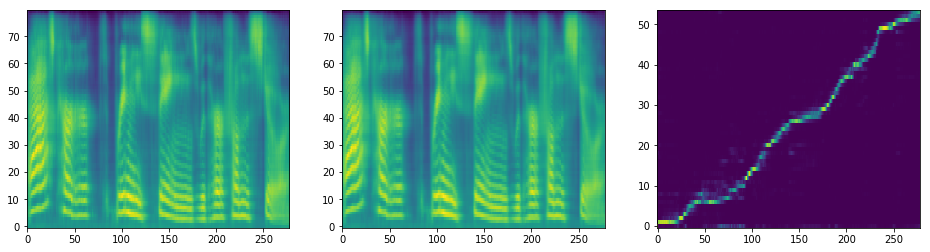

In [26]:
emotion_ref_path = '/data3/IEMOCAP/IEMOCAP_full_release_spec/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F009.npy'
audio = generate_audio(text, speaker_ref_path, emotion_ref_path)
print(audio.shape)
ipd.Audio(audio, rate=hparams.sampling_rate)

## Angry

(46800,)


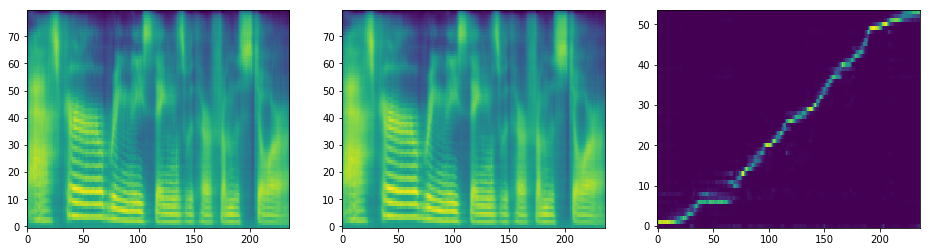

In [21]:
emotion_ref_path = '/data3/IEMOCAP/IEMOCAP_full_release_spec/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_F023.npy'
audio = generate_audio(text, speaker_ref_path, emotion_ref_path)
print(audio.shape)
ipd.Audio(audio, rate=hparams.sampling_rate)

## Fru/Sad

(43600,)


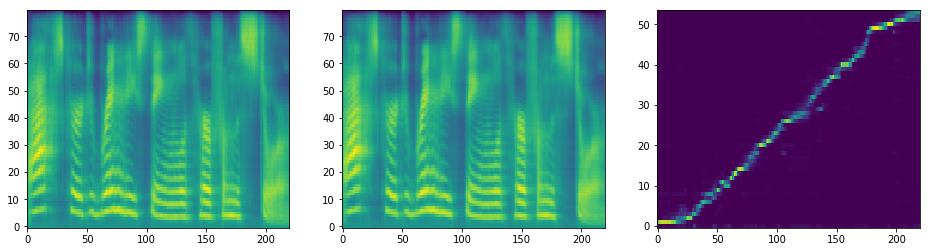

In [28]:
emotion_ref_path = '/data3/IEMOCAP/IEMOCAP_full_release_spec/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F000.npy'
audio = generate_audio(text, speaker_ref_path, emotion_ref_path)
print(audio.shape)
ipd.Audio(audio, rate=hparams.sampling_rate)

## Happy

(40200,)


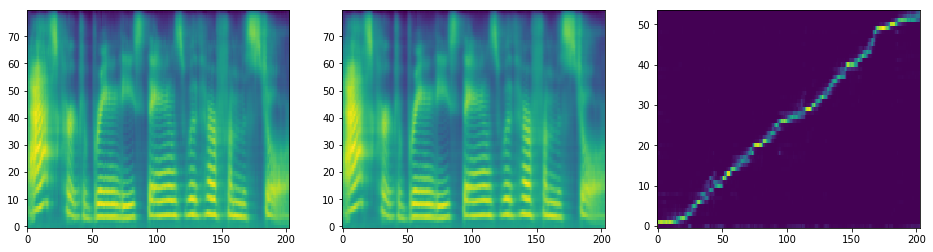

In [23]:
emotion_ref_path = '/data3/IEMOCAP/IEMOCAP_full_release_spec/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F026.npy'
text = "Ask her to bring these things with her from the store."
audio = generate_audio(text, speaker_ref_path, emotion_ref_path)
print(audio.shape)
ipd.Audio(audio, rate=hparams.sampling_rate)